<a href="https://colab.research.google.com/github/DrVaishnaviKR/chlorhexidine-survival-analysis/blob/main/Survival_Analysis_of_Chlorhexidine_Trial_Patients_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries & Load Data

In [27]:
!pip install lifelines

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# Load the data
file_path = "/content/Chlorhexidine Trials Data Cleaned.xlsx"
df = pd.read_excel(file_path)

df.head()

,treatment_group,age,gender,outcome_of_the current_episode,event,APACHEII_score,TLC_day1,time,cpis,microbial_load,organism_present
0,1,49,Male,No VAP,0,11,11900,5,3.0,50.0,0
1,1,72,Male,No VAP,0,17,16800,6,3.0,50.0,0
2,1,72,Male,No VAP,0,16,23300,8,3.0,50.0,0
3,1,55,Female,No VAP,0,29,9500,10,4.0,200.0,1
4,1,20,Male,No VAP,0,18,7000,6,0.0,90.0,0


# Exploratory Data Analysis (EDA)
1.1 Basic Structure

In [28]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   treatment_group                 106 non-null    int64  
 1   age                             106 non-null    int64  
 2   gender                          106 non-null    object 
 3   outcome_of_the current_episode  106 non-null    object 
 4   event                           106 non-null    int64  
 5   APACHEII_score                  106 non-null    int64  
 6   TLC_day1                        106 non-null    int64  
 7   time                            106 non-null    int64  
 8   cpis                            103 non-null    float64
 9   microbial_load                  103 non-null    float64
 10  organism_present                106 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 9.2+ KB


,treatment_group,age,event,APACHEII_score,TLC_day1,time,cpis,microbial_load,organism_present
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,103.000000,103.000000,106.000000
mean,1.424528,47.594340,0.094340,16.933962,15216.037736,5.716981,2.116505,213.689320,0.367925
std,0.496619,17.319286,0.293689,6.532365,7269.677884,2.377493,1.345297,157.648096,0.484532
min,1.000000,18.000000,0.000000,4.000000,2100.000000,1.000000,0.000000,10.000000,0.000000
25%,1.000000,32.000000,0.000000,12.000000,11100.000000,4.000000,1.000000,100.000000,0.000000
50%,1.000000,50.000000,0.000000,17.000000,13100.000000,5.500000,2.000000,200.000000,0.000000
75%,2.000000,62.000000,0.000000,21.000000,18150.000000,7.000000,3.000000,200.000000,1.000000
max,2.000000,75.000000,1.000000,36.000000,45000.000000,10.000000,7.000000,500.000000,1.000000


1.2 Missing Value Summary

In [29]:
df.isnull().sum()


,0
treatment_group,0
age,0
gender,0
outcome_of_the current_episode,0
event,0
APACHEII_score,0
TLC_day1,0
time,0
cpis,3
microbial_load,3


1.3 Histograms of numeric variables

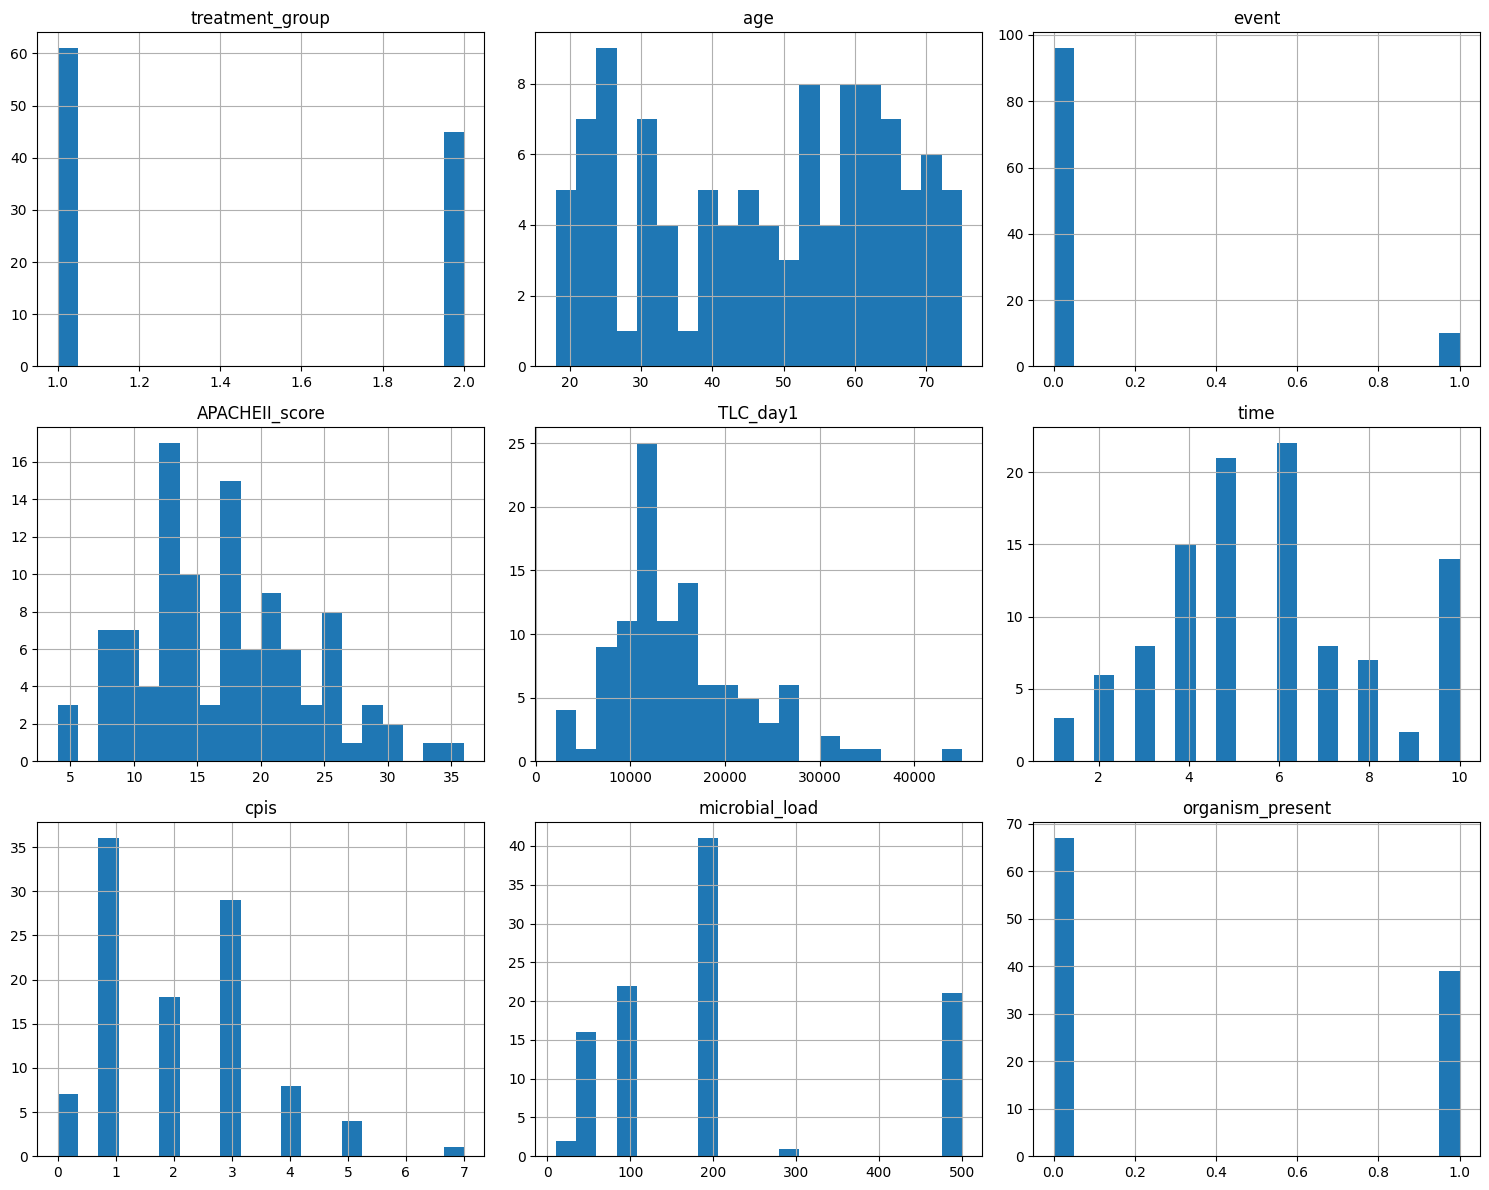

In [30]:
df.hist(figsize=(15,12), bins=20)
plt.tight_layout()
plt.show()


1.4 Boxplots (APACHE, TLC variables)

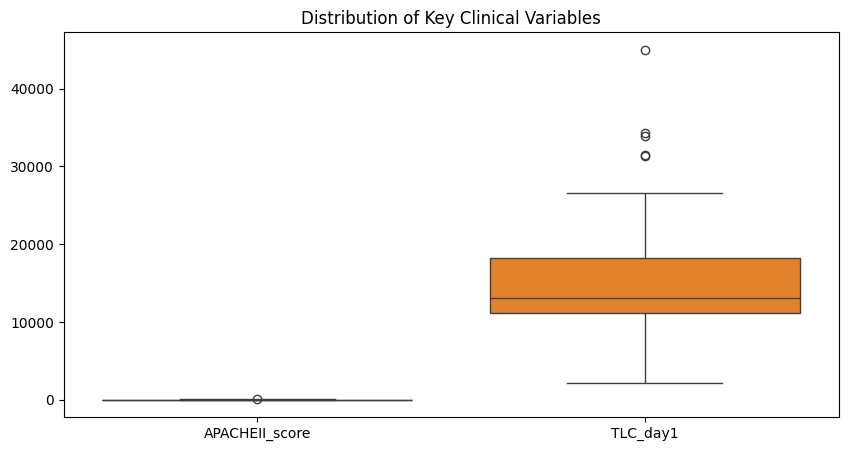

In [32]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df[['APACHEII_score','TLC_day1']])
plt.title("Distribution of Key Clinical Variables")
plt.show()

1.5 Group distribution

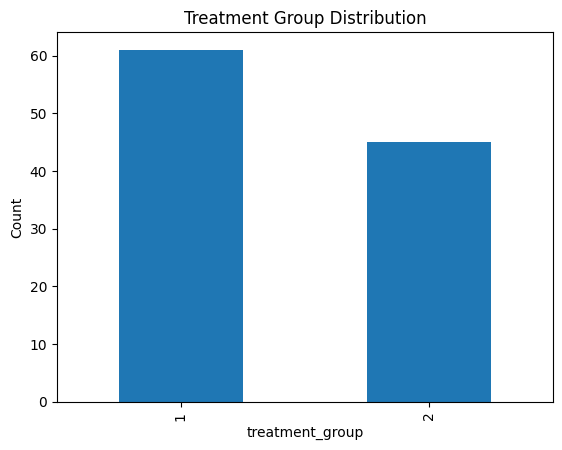

In [34]:
df['treatment_group'].value_counts().plot(kind='bar')
plt.title("Treatment Group Distribution")
plt.ylabel("Count")
plt.show()

1.6 Outcome distribution

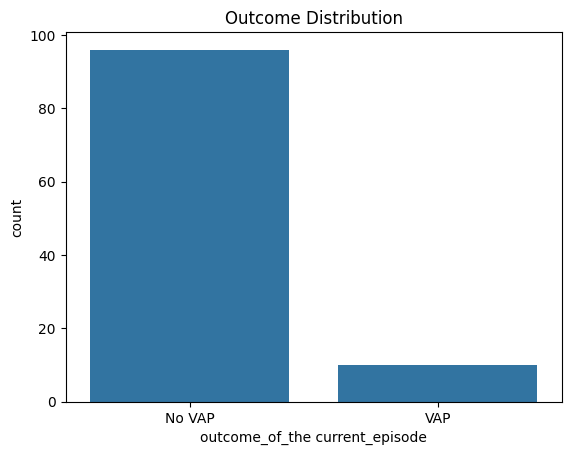

In [36]:
sns.countplot(data=df, x='outcome_of_the current_episode')
plt.title("Outcome Distribution")
plt.show()

# Kaplan–Meier Survival Curves
2.1 Fit KM model

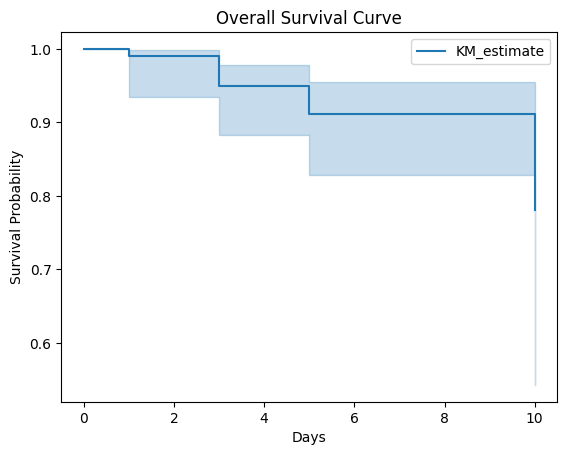

In [55]:
kmf = KaplanMeierFitter()

time = df['time']
event = df['event']

kmf.fit(time, event)
kmf.plot_survival_function()
plt.title("Overall Survival Curve")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()


2.2 KM Curves by Trial Arm

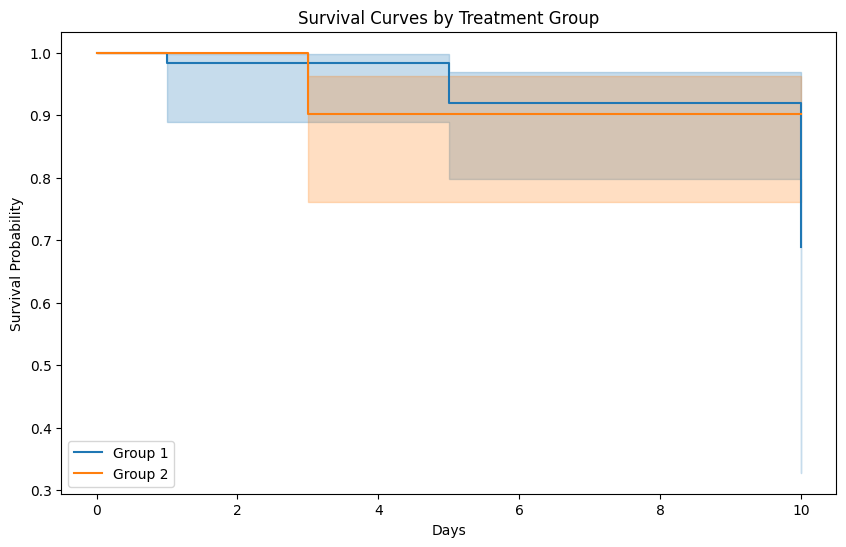

In [40]:
plt.figure(figsize=(10,6))

for arm in df['treatment_group'].unique():
    mask = df['treatment_group'] == arm
    kmf.fit(df[mask]['time'], df[mask]['event'], label=f'Group {arm}')
    kmf.plot_survival_function()

plt.title("Survival Curves by Treatment Group")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()

# Log-Rank Test (Compare Survival Distributions)

In [45]:
groupA = df[df['treatment_group'] == 1]
groupB = df[df['treatment_group'] == 2]

results = logrank_test(
    groupA['time'],
    groupB['time'],
    event_observed_A = groupA['event'],
    event_observed_B = groupB['event']
)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.94      0.08

# Cox Proportional Hazards Model
4.1 Select variables

In [47]:
cox_df = df[['time','event','age','APACHEII_score','treatment_group','organism_present']].copy()

# Convert categorical
cox_df = pd.get_dummies(cox_df, columns=['treatment_group'], drop_first=True)
cox_df.head()

,time,event,age,APACHEII_score,organism_present,treatment_group_2
0,5,0,49,11,0,False
1,6,0,72,17,0,False
2,8,0,72,16,0,False
3,10,0,55,29,1,False
4,6,0,20,18,0,False


4.2 Fit Cox Model

In [49]:
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='time', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 10
   partial log-likelihood = -39.49
         time fit was run = 2025-11-23 10:23:07 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
age               -0.01      0.99      0.02           -0.05            0.03                0.95                1.03
APACHEII_score    -0.03      0.97      0.05           -0.12            0.06                0.88                1.06
organism_present   0.83      2.28      0.66           -0.46            2.11                0.63                8.26
treatment_group_2  0.07      1.07      0.67           -1.24            1.38                0.29                3.97

                   cmp to     z    p  -log2(p)
covariate                                     
age                  0.00 -0.52 0.60      0.73
APACHEII_score       0.00 -0.68 0.49      1.02
organism_present     0.00  1.26 0.21      2.26
treatment_group_2    0.00  0.11 0.92      0.13
---
Concordance = 0.76
Partial AIC = 86.99
log-likelihood ratio test = 2.96 on 4 df
-log2(p) of ll-ratio test = 0.83

# Check Proportional Hazards (PH) Assumptions
5.1 PH Test

In [50]:
cph.check_assumptions(cox_df, p_value_threshold=0.05)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
         test_name = proportional_hazard_test

---
                        test_statistic    p  -log2(p)
APACHEII_score    km              0.00 0.95      0.07
                  rank            0.06 0.81      0.30
age               km              0.05 0.83      0.27
                  rank            0.00 0.95      0.07
organism_present  km              5.15 0.02      5.42
                  rank            2.43 0.12      3.07
treatment_group_2 km              1.54 0.21      2.22
                  rank            2.16 0.14      2.82



1. Variable 'organism_present' failed the non-proportional test: p-value is 0.0233.

   Advice: with so few unique values (only 2), you can include `strata=['organism_present', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[]

# Final Visualizations & Interpretation
6.1 Preparing Data for Cox Regression

In [57]:
# prepare numeric cox_data (this is the dataframe we will use for fit & PH test)
model_cols = ['time','event','age','APACHEII_score','TLC_day1','treatment_group']


if 'Gender_binary' in df.columns:
    model_cols.append('Gender_binary')
else:
    gender_dummy_cols = [c for c in df.columns if c.startswith('gender_')]
    model_cols += gender_dummy_cols

# ensure all exist
missing = [c for c in model_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing model cols: {missing}")

cox_data = df[model_cols].copy()

# coerce to numeric and impute median for predictors if necessary (time/event must not be NA)
for c in cox_data.columns:
    if c in ['time','event']:
        if cox_data[c].isna().any():
            raise ValueError(f"Column {c} contains missing values; fix before modeling.")
        continue

    cox_data[c] = pd.to_numeric(cox_data[c], errors='coerce')
    if cox_data[c].isna().any():
        med = cox_data[c].median()
        cox_data[c].fillna(med, inplace=True)
        print(f"Imputed {c} missing values with median={med}")

display(cox_data.describe().T)

,count,mean,std,min,25%,50%,75%,max
time,106.0,5.716981,2.377493,1.0,4.0,5.5,7.0,10.0
event,106.0,0.094340,0.293689,0.0,0.0,0.0,0.0,1.0
age,106.0,47.594340,17.319286,18.0,32.0,50.0,62.0,75.0
APACHEII_score,106.0,16.933962,6.532365,4.0,12.0,17.0,21.0,36.0
TLC_day1,106.0,15216.037736,7269.677884,2100.0,11100.0,13100.0,18150.0,45000.0
treatment_group,106.0,1.424528,0.496619,1.0,1.0,1.0,2.0,2.0


6.2 Cox Proportional Hazards Model

In [58]:

cph = CoxPHFitter()
cph.fit(cox_data, duration_col='time', event_col='event')

print("Cox PH summary:")
cph.print_summary()


Cox PH summary:


<lifelines.CoxPHFitter: fitted with 106 total observations, 96 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 106
number of events observed = 10
   partial log-likelihood = -40.15
         time fit was run = 2025-11-23 12:28:52 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
age             -0.01      0.99      0.02           -0.05            0.02                0.95                1.02
APACHEII_score  -0.04      0.96      0.05           -0.13            0.06                0.88                1.06
TLC_day1        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
treatment_group  0.13      1.13      0.67           -1.19            1.44                0.30                4.22

                 cmp to     z    p  -log2(p)
covariate                                   
age                0.00 -0.75 0.45      1.14
APACHEII_score     0.00 -0.77 0.44      1.19
TLC_day1           0.00 -0.53 0.60      0.74
treatment_group    0.00  0.19 0.85      0.23
---
Concordance = 0.60
Partial AIC = 88.31
log-likelihood ratio test = 1.64 on 4 df
-log2(p) of ll-ratio test = 0.32

6.3 Checking Proportional Hazards Assumption

Running proportional hazards checks (Schoenfeld residuals). Visuals will appear below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3


   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.46334e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.46716e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)



   Bootstrapping lowess lines. May take a moment...



/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.17068e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.1452e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.9315e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9969)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9246)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8542)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9459)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5481)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5703)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0949)'>,
  <Axes: xlabel='km-transformed time\n(p=0.1257)'>]]

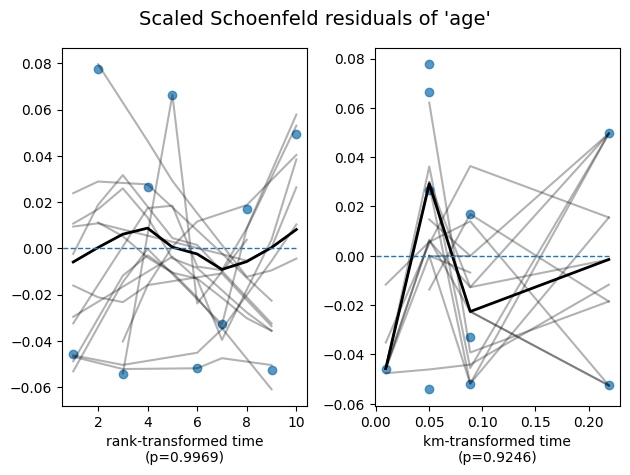

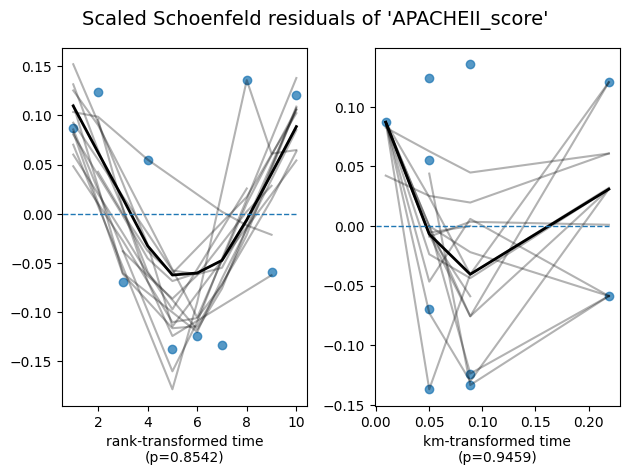

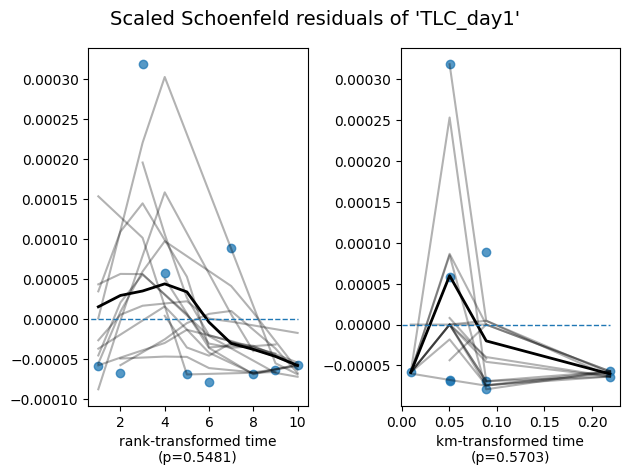

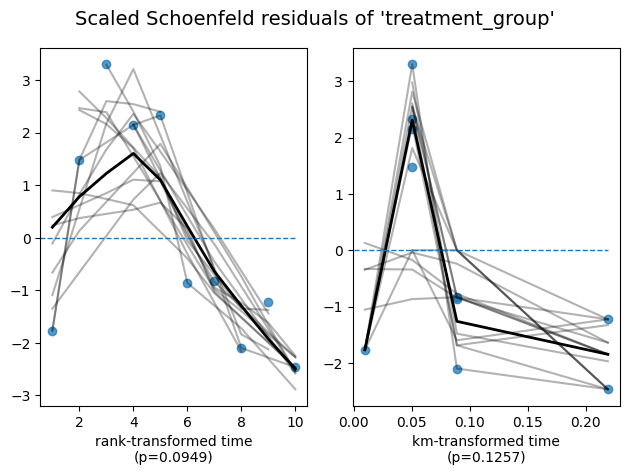

In [59]:
#proportional hazards check
print("Running proportional hazards checks (Schoenfeld residuals). Visuals will appear below.")
cph.check_assumptions(cox_data, p_value_threshold=0.05, show_plots=True)


6.4 Forest Plot of Hazard Ratios

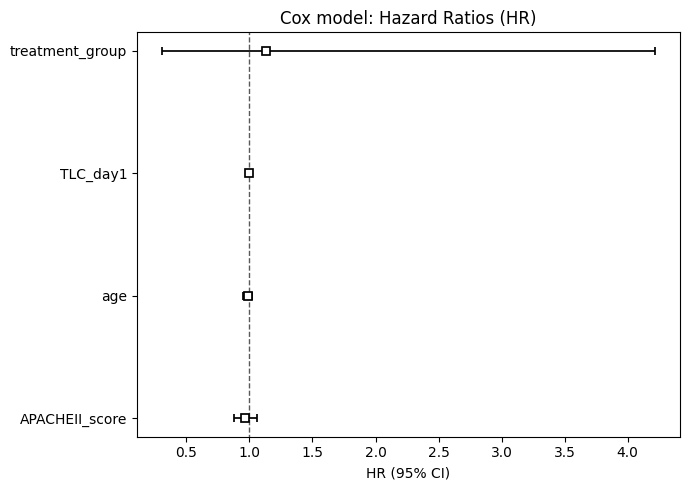

In [60]:
# forest plot
plt.figure(figsize=(7,5))
cph.plot(hazard_ratios=True)
plt.title("Cox model: Hazard Ratios (HR)")
plt.tight_layout()
plt.show()


6.5 Partial Effects and Adjusted Survival Curves

<Figure size 800x600 with 0 Axes>

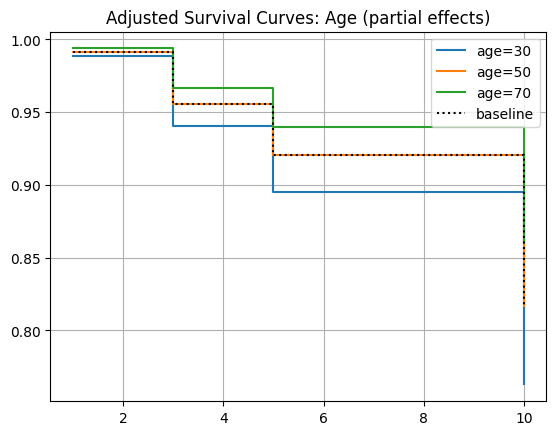

<Figure size 800x600 with 0 Axes>

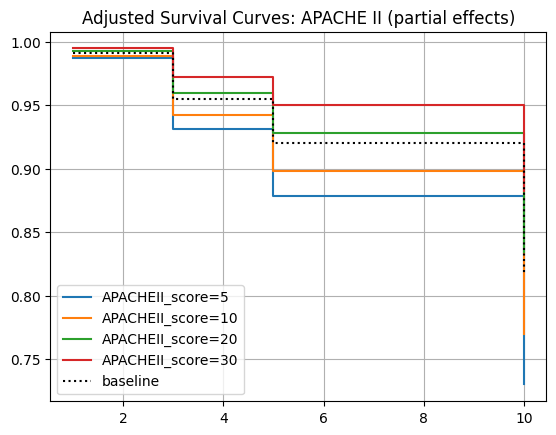

<Figure size 800x600 with 0 Axes>

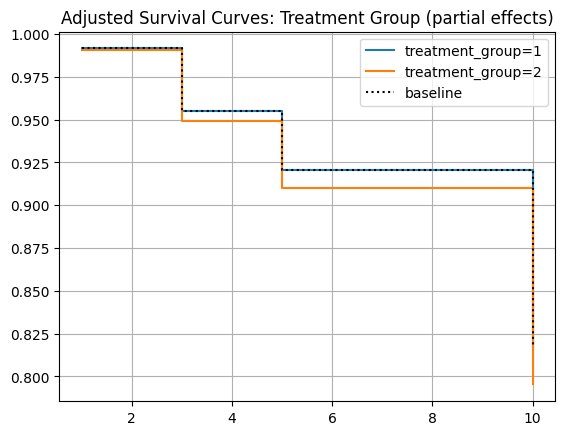

In [62]:
# Partial effects (examples): Age, APACHEII, TLC_D1, TrialArm_num

# Age
plt.figure(figsize=(8,6))
cph.plot_partial_effects_on_outcome(covariates='age', values=[30,50,70])
plt.title("Adjusted Survival Curves: Age (partial effects)")
plt.grid(True)
plt.show()

# APACHEII
plt.figure(figsize=(8,6))
cph.plot_partial_effects_on_outcome(covariates='APACHEII_score', values=[5,10,20,30])
plt.title("Adjusted Survival Curves: APACHE II (partial effects)")
plt.grid(True)
plt.show()

# TrialArm numeric
plt.figure(figsize=(8,6))
cph.plot_partial_effects_on_outcome(covariates='treatment_group', values=[1,2])
plt.title("Adjusted Survival Curves: Treatment Group (partial effects)")
plt.grid(True)
plt.show()